In [1]:
run run_residuals -v -o 2

/Users/Natalie/Code/apogee/apogee/spec/window.py:88: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True-numpy.isnan(win))).astype('int')


AttributeError: 'int' object has no attribute 'values'

In [2]:
hidefigs = False
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


badpix,  [335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 1245, 1246, 1247, 2283, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3814, 3815, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4509, 4510, 4511, 4512, 4513, 4514, 5328, 5329, 5330, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6229, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075]
       iter        R2             rchi2
EMPCA  1/25       0.02379727      0.00004558
EMPCA  2/25       0.45069771      0.00002172
EMPCA  3/25       0.52661005      0.00001889
EMPCA  4/25       0.55904353      0.00001791
EMPCA  5/25       0.57038374      0.00001758
EMPCA  6/25       0.57511364      0.00001745
EMPCA  7/25     

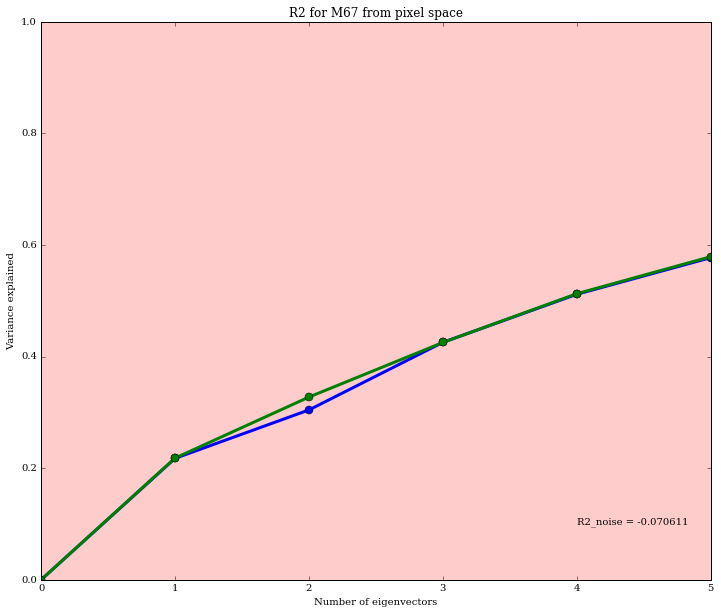

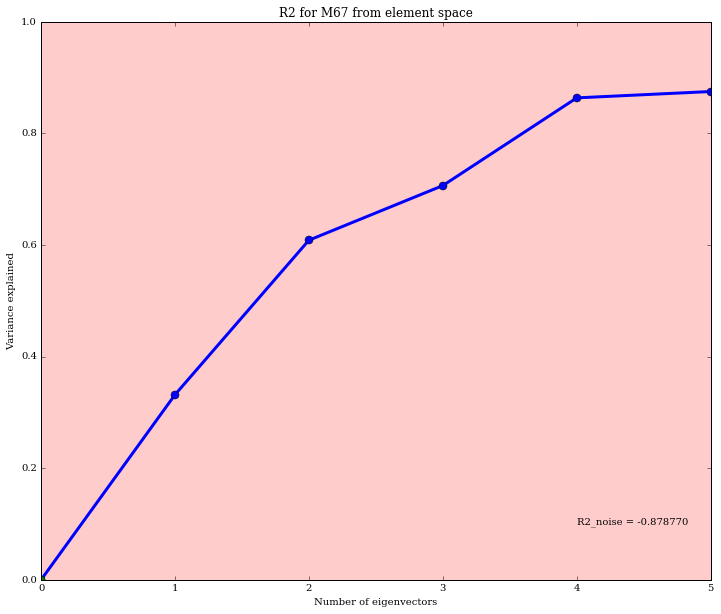

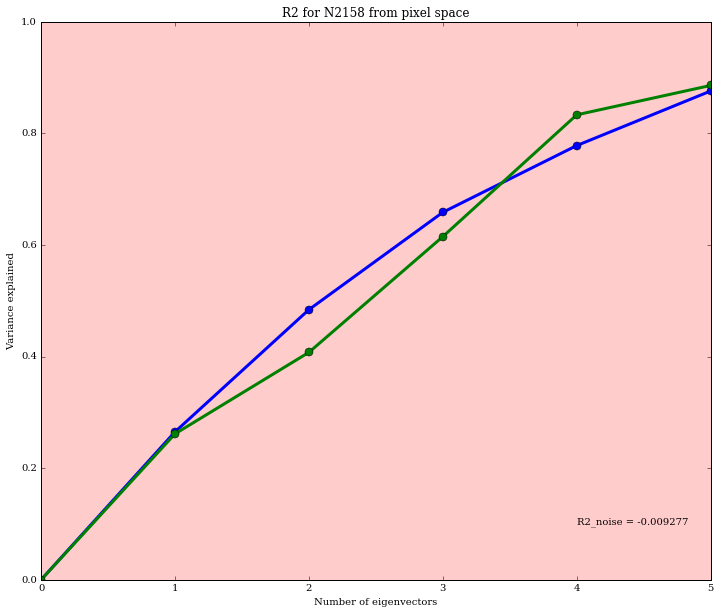

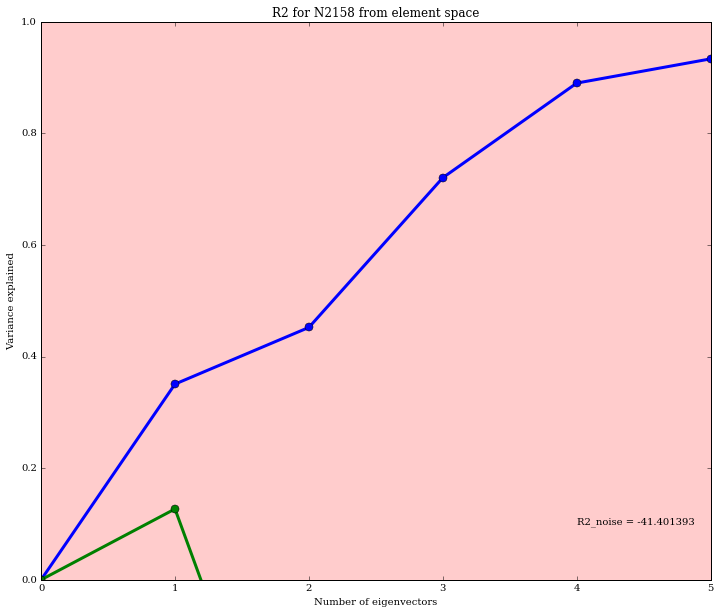

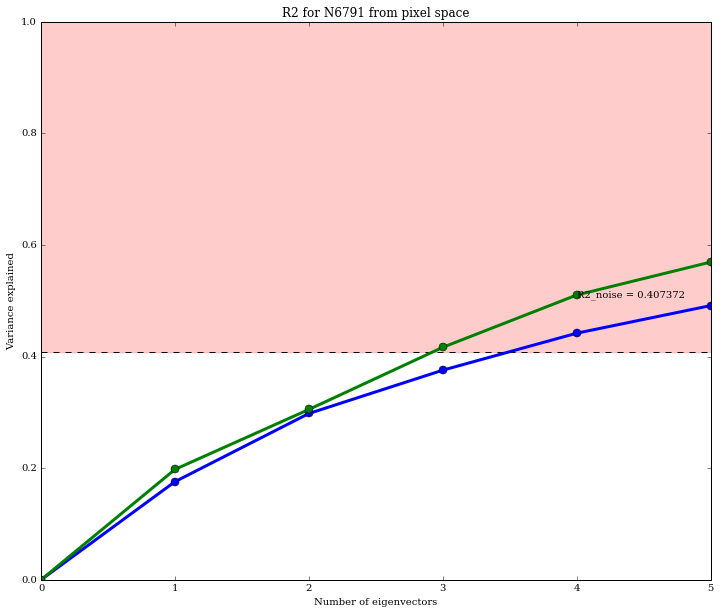

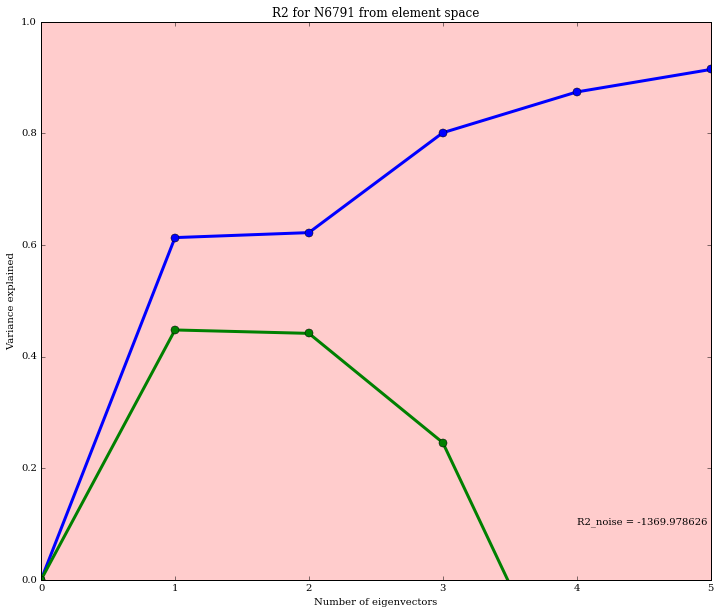

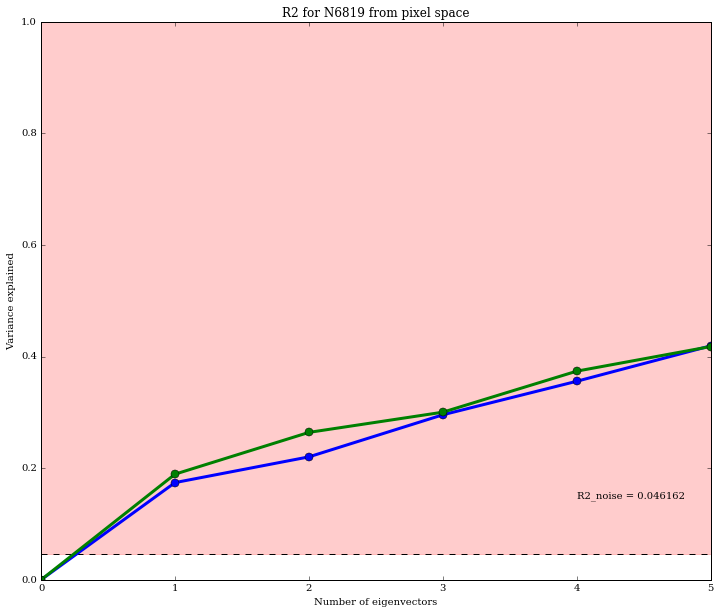

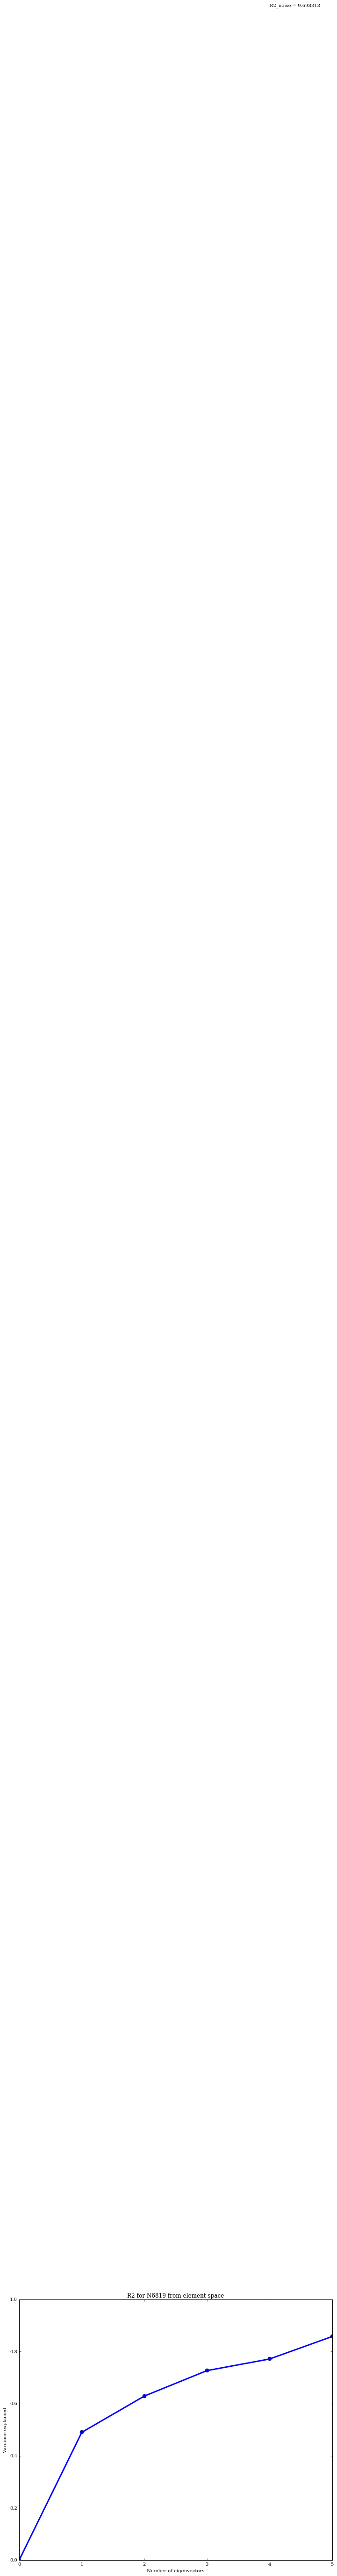

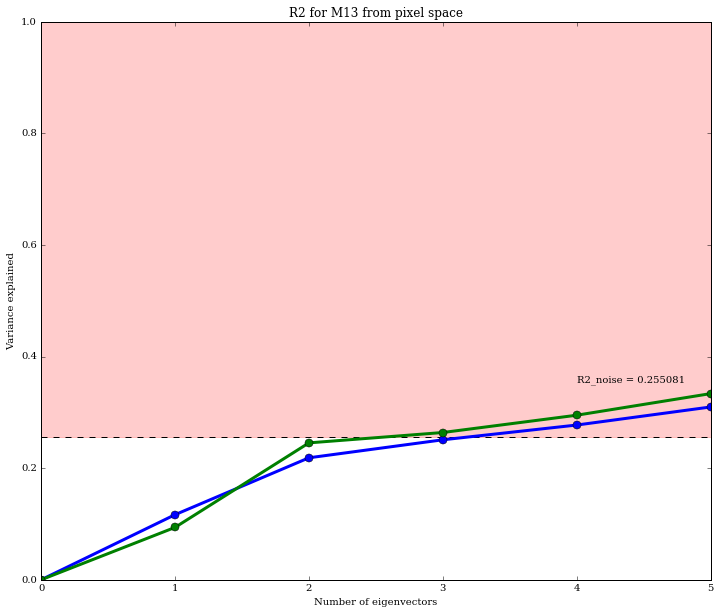

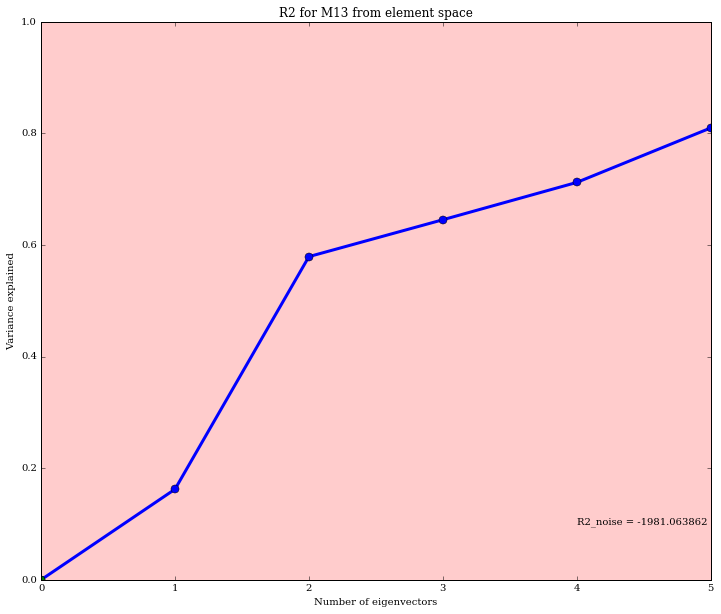

In [10]:
run run_empca -vug -m clusters/pickles/model.pkl -d 2e-3

In [5]:
subgroup

'M67'

In [ ]:
totalstars = np.sum(starsample.numstars.values())
clustersstars = 0
for subgroup in ['M67','N2158','N6791','N6819']:
    clustersstars += starsample.numstars[subgroup]
allresids = np.ma.masked_array(np.zeros((clustersstars,aspcappix)))
allsigmas = np.ma.masked_array(np.zeros((clustersstars,aspcappix)))
apoSNR = np.zeros((totalstars))
maSNR = np.zeros((totalstars))
i = 0
j = 0
for subgroup in starsample.subgroups:
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    if subgroup in ['M67','N2158','N6791','N6819']:
        allresids[j:j+starsample.numstars[subgroup]] = starsample.residual[subgroup].T
        allsigmas[j:j+starsample.numstars[subgroup]] = starsample.errs[match]
        j+=starsample.numstars[subgroup]
    apoSNR[i:i+starsample.numstars[subgroup]] = starsample.data[match]['SNR']
    maSNR[i:i+starsample.numstars[subgroup]] = np.ma.mean(starsample.specs[match]/starsample.errs[match],axis=1)
    i += starsample.numstars[subgroup]

In [ ]:
errhist,errbins = np.histogram(starsample.specs[starsample.specs.mask==False]/starsample.errs[starsample.errs.mask==False],bins = 20)
plt.figure()
plt.bar(errbins[:-1],errhist/float(max(errhist)),width = (errbins[1]-errbins[0]),label='APOGEE SNR',alpha=0.5)
plt.axvline(50,color='red')
plt.axvline(200,color='red')

In [ ]:
# Plot SNR histogram

SNRhist,SNRbins = np.histogram(apoSNR,bins = 50,range=(50,300))
maSNRhist,maSNRbins = np.histogram(maSNR,bins=50,range=(50,300))
plt.figure()
plt.bar(SNRbins[:-1],SNRhist,width = (SNRbins[1]-SNRbins[0]),label='APOGEE SNR',alpha=0.5)
plt.bar(maSNRbins[:-1],maSNRhist,width = (maSNRbins[1]-maSNRbins[0]),color='green',alpha=0.5,label='SNR after masking')
plt.axvline(200,color='r')
plt.axvline(50,color='r')
plt.xlabel('SNR')
plt.ylabel('Number of stars')
plt.legend(loc = 'best')


In [ ]:
# Do EMPCA for each cluster individually
nvecs = 5

import empca
reload(empca)
from empca import empca

gen = True

for subgroup in starsample.subgroups:
    print subgroup
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    empcaname = starsample.outName('pkl',content = 'empca',subgroup=subgroup,order = starsample.order,seed = starsample.seed,cross=starsample.cross)
    empcaname = empcaname.split('.pkl')[0]+'_nvec{0}'.format(nvecs)+'.pkl'
    goodpix = ([i for i in range(aspcappix) if np.sum(starsample.residual[subgroup][i].mask) < starsample.numstars[subgroup]-5],)
    print len(goodpix[0])
    badpix = ([i for i in range(aspcappix) if np.sum(starsample.residual[subgroup][i].mask) >= starsample.numstars[subgroup]-5],)
    if os.path.isfile(empcaname) and not gen:
        empcamodel,empcamodel_weight = acs.pklread(empcaname)
    elif not os.path.isfile(empcaname) or gen:
        empca_res = starsample.residual[subgroup][goodpix].T
        print empca_res.shape
        mask = (empca_res.mask==False)
        weights = mask.astype(int)
        print weights.shape
        sigmas = starsample.errs[match].T[goodpix].T
        weights[mask] = 1./sigmas[mask]**2
        empcamodel,runtime1 = timeIt(empca,empca_res.data,weights = mask.astype(int),nvec=nvecs)
        print 'Runtime:', runtime1/60.,' min'
        empcamodel_weight,runtime2 = timeIt(empca,empca_res.data,weights = weights,nvec=nvecs)
        print 'Runtime:', runtime2/60.,' min'
        acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])

    # Check this with random sigma
    Vnoise = (1./(len(match[0])*len(goodpix[0])))*np.ma.sum(np.ma.sum(starsample.errs[match].T[goodpix]**2,axis=0))
    Vnoise = (np.mean(1./weights[weights!=0]))
    # and with MAD as estimate of Vnoise from random sigma
    R2noise = 1 - Vnoise/(empcamodel._unmasked_data_mad2*1.4826**2.)
    print 'VNOISE, ',Vnoise
    print 'MAD, ',empcamodel._unmasked_data_mad2*1.4826**2.
    print 'VAR, ',empcamodel._unmasked_data_var
    print 'R2noise, ',R2noise
    R2 = np.zeros(nvecs+1)
    R2_w = np.zeros(nvecs+1)
    for vec in range(nvecs+1):
        R2[vec] = empcamodel.R2(vec,mad=True)
        R2_w[vec] = empcamodel_weight.R2(vec,mad=True)

    empcamodel.eigvec.resize((nvecs,aspcappix))
    empcamodel_weight.eigvec.resize((nvecs,aspcappix))

    neweigvecs = np.zeros((nvecs,len(elems)))
    neweigvecs_w = np.zeros((nvecs,len(elems)))
    for ind in range(len(elems)):
        for vec in range(nvecs):
            newvec = np.ma.masked_array(np.zeros((aspcappix)),mask = np.zeros((aspcappix)))
            newvec[goodpix] = empcamodel.eigvec[vec][:len(goodpix[0])]
            newvec.mask[badpix] = 1
            empcamodel.eigvec[vec] = newvec
            newvec = np.ma.masked_array(np.zeros((aspcappix)),mask = np.zeros((aspcappix)))
            newvec[goodpix] = empcamodel_weight.eigvec[vec][:len(goodpix[0])]
            newvec.mask[badpix] = 1
            empcamodel_weight.eigvec[vec] = newvec
            neweigvecs[vec][ind] = starsample.weighting(empcamodel.eigvec[vec],elems[ind])
            neweigvecs_w[vec][ind] = starsample.weighting(empcamodel_weight.eigvec[vec],elems[ind])

    # Create weighted residuals
    weighted = np.ma.masked_array(np.zeros((len(elems),starsample.numstars[subgroup])))
    weightedsigs = np.ma.masked_array(np.zeros((len(elems),starsample.numstars[subgroup])))
    i=0
    for elem in elems:
        weightedr = starsample.weighting_stars(starsample.residual[subgroup],elem,
                                               starsample.outName('pkl','resids',elem=elem,
                                                                  order = starsample.order,
                                                                  subgroup=subgroup,
                                                                  cross=starsample.cross))
        weighteds = starsample.weighting_stars(starsample.sigma[subgroup].T,elem,
                                               starsample.outName('pkl','sigma',elem=elem,
                                                                  order = starsample.order,
                                                                  subgroup=subgroup,
                                                                  seed = starsample.seed))
        doubleResidualHistPlot(elem,weightedr,weighteds,
                               starsample.outName('res','residhist',elem = elem,order = starsample.order,
                                                  cross=starsample.cross,seed = starsample.seed,subgroup = subgroup),
                               bins = 50)
        weighted[i] = weightedr
        weightedsigs[i] = weighteds
        i+=1

    # Do EMPCA on weighted residuals
    empcaname = starsample.outName('pkl',content = 'empca_element',order = starsample.order,
                                   seed = starsample.seed,cross=starsample.cross,subgroup=subgroup)
    empcaname = empcaname.split('.pkl')[0]+'_nvec{0}'.format(nvecs)+'.pkl'
    if os.path.isfile(empcaname):
        wempcamodel,wempcamodel_weight = acs.pklread(empcaname)
    elif not os.path.isfile(empcaname):
        mask = np.ones(weighted.T.shape)
        weights = 1./np.sqrt(weightedsigs.T**2) # Correct?
        wempcamodel,runtime1 = timeIt(empca,weighted.T.data,weights = mask.astype(int),nvec=nvecs)
        print 'Runtime:', runtime1/60.,' min'
        wempcamodel_weight,runtime2 = timeIt(empca,weighted.T.data,weights = weights,nvec=nvecs)
        print 'Runtime:', runtime2/60.,' min'
        acs.pklwrite(empcaname,[wempcamodel,wempcamodel_weight])

    # Calculate wR2noise
    wR2 = np.zeros(nvecs)
    wR2_w = np.zeros(nvecs)
    for vec in range(nvecs):
        wR2[vec] = wempcamodel.R2(vec)
        wR2_w[vec] = wempcamodel_weight.R2(vec)

    # with variance and with mad2 weighting
    plt.figure(figsize=(16,14))
    plt.plot(range(nvecs+1),R2,label='Unweighted EMPCA - raw')
    plt.plot(range(nvecs+1),R2_w,label='Weighted EMPCA - raw')
    #plt.plot(range(nvecs),wR2,label='Unweighted EMPCA - proc')
    #plt.plot(range(nvecs),wR2_w,label='Weighted EMPCA - proc')
    plt.ylim(0,1)
    plt.axhline(R2noise,linestyle='--',color='k',label='Noise Threshold')
    plt.xlabel('Number of eigenvectors')
    plt.ylabel('Variance')
    plt.legend(loc='best')
    plt.xlim(0,nvecs)
    plt.title(subgroup)
    plt.savefig('./{0}/empca/empcaR2_{1}_order{2}_seed{3}_cross{4}_nvec{5}.png'.format(starsample.type,subgroup, starsample.order,starsample.seed,starsample.cross,nvecs))
    if hidefigs:
        plt.close()
      
    colors = {0:'b',1:'g',2:'r',3:'c'}
    # Normalize vectors
    for vec in range(1):
        pixvec = neweigvecs[vec]/np.sqrt(np.sum(neweigvecs[vec]**2))
        pixvec_w = neweigvecs_w[vec]/np.sqrt(np.sum(neweigvecs_w[vec]**2))
        elemvec = wempcamodel.eigvec[vec]/np.sqrt(np.sum(wempcamodel.eigvec[vec]**2))
        elemvec_w = wempcamodel_weight.eigvec[vec]/np.sqrt(np.sum(wempcamodel_weight.eigvec[vec]**2))
        plt.figure(figsize=(16,14))
        plt.xticks(range(len(elems)),elems)
        plt.axhline(0,color='k')
        for i in range(len(elems)):
            colors = {pixvec[i]:'b',pixvec_w[i]:'g',elemvec[i]:'r',elemvec_w[i]:'c'}
            order = colors.keys()
            order = sorted(order,key = abs)[::-1]
            for val in order:
                plt.plot([i,i],[0,val],color=colors[val],linewidth=3)
        plt.plot(pixvec,'bo',label='Unweighted EMPCA - raw',markersize=10)
        plt.plot(pixvec_w,'gs',label='Weighted EMPCA - raw',markersize=8)
        plt.plot(elemvec,'rv',label = 'Unweighted EMPCA - proc',markersize=10)
        plt.plot(elemvec_w,'cD', label = 'Weighted EMPCA - proc',markersize=8)
        plt.xlim(-1,len(elems))
        plt.legend(loc='best')
        plt.xlabel('Elements')
        plt.ylabel('Eigenvector')
        plt.title('{0} eigenvector, weighted by element, {1}'.format(vec,subgroup))
        plt.savefig('./{0}/empca/{1}empcaeig{2}_order{3}_seed{4}_cross{5}_nvec{6}.png'.format(starsample.type,subgroup,vec, starsample.order,starsample.seed,starsample.cross,label,up,low,nvecs))
        if hidefigs:
            plt.close()


In [ ]:
np.median(empca_res[empcamodel._unmasked])

In [ ]:
np.sum(np.ma.median(np.fabs(empca_res-np.ma.median(empca_res)))**2)

In [ ]:
empcaname = starsample.outName('pkl',content = 'empca',order = starsample.order,seed = starsample.seed,cross=starsample.cross)
empcaname = empcaname.split('pkl')[0]+'nvec{0}'.format(nvecs)+'.pkl'
if os.path.isfile(empcaname):
    empcamodel,empcamodel_weight = acs.pklread(empcaname)
elif not os.path.isfile(empcaname):
    mask = (allresids.mask==False)
    weights = mask.astype(int)
    weights[mask] = 1./np.sqrt(allsigmas[mask]**2) # Correct?
    empcamodel,runtime1 = timeIt(empca,allresids,weights = mask.astype(float),nvec=nvecs)
    print 'Runtime:', runtime1/60.,' min'
    empcamodel_weight,runtime2 = timeIt(empca,allresids,weights = weights,nvec=nvecs)
    print 'Runtime:', runtime2/60.,' min'
    acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])

In [ ]:
Vnoise = (1./(len(allsigmas)*aspcappix))*np.ma.sum(np.ma.sum(allsigmas,axis=1))
R2noise = 1 - Vnoise/np.ma.var(allresids)
R2 = np.zeros(nvecs)
R2_w = np.zeros(nvecs)
for vec in range(nvecs):
    R2[vec] = empcamodel.R2(vec)
    R2_w[vec] = empcamodel_weight.R2(vec)

In [ ]:
plt.figure()
plt.plot(range(nvecs),R2,label='Unweighted EMPCA')
plt.plot(range(nvecs),R2_w,label='Weighted EMPCA')
plt.axhline(R2noise,color='red',label='Noise Threshold')
plt.xlabel('Number of eigenvectors')
plt.ylabel('Variance')
plt.legend(loc='best')
plt.xlim(0,nvecs-1)
plt.savefig('./{0}/empca/empcaR2_order{1}_seed{2}_cross{3}_nvec{4}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,nvecs))
if hidefigs:
    plt.close()

In [ ]:
rcovlim = 1e-4
nrcovlim = 4.5
hidefigs=False
for subgroup in starsample.subgroups:
    print subgroup
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    residcov = np.ma.cov(starsample.residual[subgroup])
    normresidcov = np.ma.cov(starsample.residual[subgroup]/starsample.errs[match].T)
    
    # Plot covariance of raw pixel residuals
    plt.figure(figsize=(10,12))
    plt.imshow(residcov,interpolation='nearest',cmap = 'Spectral',vmin=-rcovlim,vmax=rcovlim)
    plt.colorbar()
    plt.savefig('./{0}/covariance/{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # Plot covariance of residuals divided by pixel flux uncertainty
    plt.figure(figsize=(10,12))
    plt.imshow(normresidcov,interpolation='nearest',cmap = 'Spectral',vmin=-nrcovlim,vmax=nrcovlim)
    plt.colorbar()
    plt.savefig('./{0}/covariance/norm_{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # PLOT.DETECTOR FOR BETTER RANGES
    # Plot diagonal of covariance of raw pixel residuals
    plt.figure(figsize=(16,4))
    diag = np.array([residcov[i,i] for i in range(len(residcov))])
    plt.plot(diag)
    plt.xlim(0,len(diag))
    plt.ylim(0,rcovlim)
    plt.xlabel('Pixel')
    plt.ylabel('Variance')
    plt.savefig('./{0}/covariance/diag_{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # Plot diagonal of  covariance of residuals divided by pixel flux uncertainty
    plt.figure(figsize=(16,4))
    normdiag = np.array([normresidcov[i,i] for i in range(len(normresidcov))])
    plt.plot(normdiag,linewidth = 0.5)
    plt.xlim(0,len(normdiag))
    plt.ylim(0,nrcovlim)
    plt.xlabel('Pixel')
    plt.ylabel('Variance')
    plt.savefig('./{0}/covariance/normdiag_{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # Plot two slices of the covariance matrices
    samppix = 3700
    plt.figure(figsize=(16,8))
    plt.plot(residcov[samppix]/residcov[samppix][samppix],label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
    plt.plot(normresidcov[samppix]/normresidcov[samppix][samppix],label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
    plt.axvline(samppix,color='red')
    plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
    plt.xlabel('Pixel')
    plt.xlim(samppix-100,samppix+100)
    plt.legend(loc = 'best')
    plt.savefig('./{0}/covariance/pix{1}_{2}_order{3}_seed{4}_cross{5}.png'.format(starsample.type, samppix,subgroup,starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    samppix = 6000
    plt.figure(figsize=(16,8))
    plt.plot(residcov[samppix]/residcov[samppix][samppix],label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
    plt.plot(normresidcov[samppix]/normresidcov[samppix][samppix],label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
    plt.axvline(samppix,color='red')
    plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
    plt.xlabel('Pixel')
    plt.xlim(samppix-100,samppix+100)
    plt.legend(loc = 'best')
    plt.savefig('./{0}/covariance/pix{1}_{2}_order{3}_seed{4}_cross{5}.png'.format(starsample.type, samppix,subgroup,starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

In [ ]:
residcov = np.ma.cov(allresids.T)
normresidcov = np.ma.cov(allresids.T/allsigmas.T)

In [ ]:
rcovlim = 1e-4
nrcovlim = 4

In [ ]:
# Plot covariance of raw pixel residuals
plt.figure(figsize=(10,12))
plt.imshow(residcov,interpolation='nearest',cmap = 'Spectral',vmax=rcovlim,vmin=-rcovlim)
plt.colorbar()
plt.savefig('./{0}/covariance/order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot covariance of residuals divided by pixel flux uncertainty
plt.figure(figsize=(10,12))
plt.imshow(normresidcov,interpolation='nearest',cmap = 'Spectral',vmax=nrcovlim,vmin=-nrcovlim)
plt.colorbar()
plt.savefig('./{0}/covariance/norm_order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot diagonal of covariance of raw pixel residuals
plt.figure(figsize=(16,4))
diag = np.array([residcov[i,i] for i in range(len(residcov))])
plt.plot(diag)
plt.xlim(0,len(diag))
plt.ylim(0,rcovlim)
plt.xlabel('Pixel')
plt.ylabel('Variance')
plt.savefig('./{0}/covariance/diag_order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot diagonal of  covariance of residuals divided by pixel flux uncertainty
plt.figure(figsize=(16,4))
normdiag = np.array([normresidcov[i,i] for i in range(len(normresidcov))])
plt.plot(normdiag,linewidth = 0.5)
plt.xlim(0,len(normdiag))
plt.ylim(0,nrcovlim)
plt.xlabel('Pixel')
plt.ylabel('Variance')
plt.savefig('./{0}/covariance/normdiag_order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot two slices of the covariance matrices
samppix = 3700
plt.figure(figsize=(16,8))
plt.plot(residcov[samppix]/np.max(residcov[samppix]),label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
plt.plot(normresidcov[samppix]/np.max(normresidcov[samppix]),label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
plt.axvline(samppix,color='red')
plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
plt.xlabel('Pixel')
plt.xlim(samppix-100,samppix+100)
plt.legend(loc = 'best')
plt.savefig('./{0}/covariance/pix{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, samppix,starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

samppix = 6000
plt.figure(figsize=(16,8))
plt.plot(residcov[samppix]/np.max(residcov[samppix]),label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
plt.plot(normresidcov[samppix]/np.max(normresidcov[samppix]),label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
plt.axvline(samppix,color='red')
plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
plt.xlabel('Pixel')
plt.xlim(samppix-100,samppix+100)
plt.legend(loc = 'best')
plt.savefig('./{0}/covariance/pix{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, samppix,starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()